In [3]:
!gdown 1nQDUEBgCF8087nPuLxNfBgJFeaJPaWoq
# Configure Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Retinal Disease Classification dataset
!kaggle datasets download -d abdallahwagih/retina-blood-vessel

Downloading...
From: https://drive.google.com/uc?id=1nQDUEBgCF8087nPuLxNfBgJFeaJPaWoq
To: /content/kaggle.json
100% 69.0/69.0 [00:00<00:00, 280kB/s]
Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel
License(s): apache-2.0
 27% 9.00M/32.9M [00:00<00:00, 65.7MB/s]
100% 32.9M/32.9M [00:00<00:00, 154MB/s] 


In [4]:
!unzip -qq retina-blood-vessel -d data
!rm -rf retina-blood-vessel.zip

In [39]:
import plotly.express as px
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [5]:
# Paths to train and test datasets
train_path = "data/Data/train/image"
test_path = "data/Data/test/image"

# Parameters
IMG_SIZE = 128  # Resize all images to 128x128

# Function to load and preprocess images from a directory
def load_images_from_directory(directory):
    images = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to IMG_SIZE x IMG_SIZE
            img = img / 255.0  # Normalize pixel values
            images.append(img)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
    return np.array(images, dtype="float32")

# Load train and test images
X_train = load_images_from_directory(train_path)
X_test = load_images_from_directory(test_path)

print(f"Training samples: {len(X_train)}, Image shape: {X_train.shape[1:]}")
print(f"Testing samples: {len(X_test)}, Image shape: {X_test.shape[1:]}")

Training samples: 80, Image shape: (128, 128)
Testing samples: 20, Image shape: (128, 128)


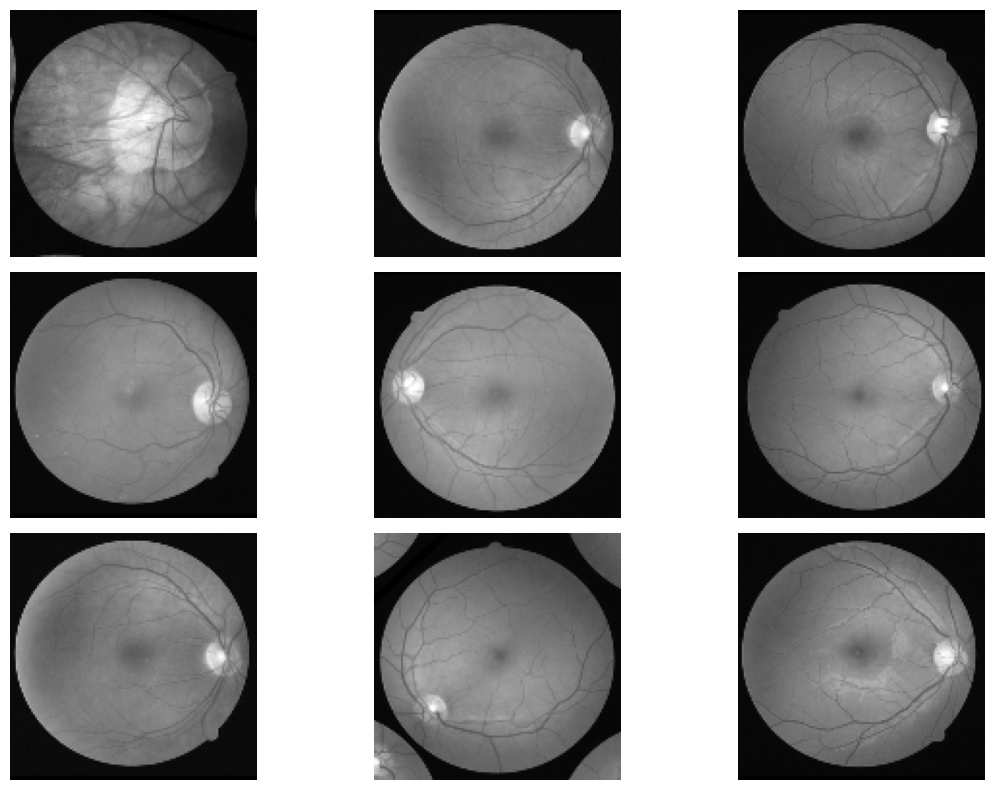

In [9]:
import matplotlib.pyplot as plt

# Function to display a grid of images
def display_images(images, titles=None, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.ravel()  # Flatten the axes array for easier iteration
    for i in range(min(rows * cols, len(images))):
        axes[i].imshow(images[i], cmap='gray')  # Display the image in grayscale
        if titles:
            axes[i].set_title(titles[i])
        axes[i].axis('off')  # Hide the axis ticks and labels
    plt.tight_layout()
    plt.show()

# Display some sample images from the training set
display_images(X_train[:9], rows=3, cols=3)

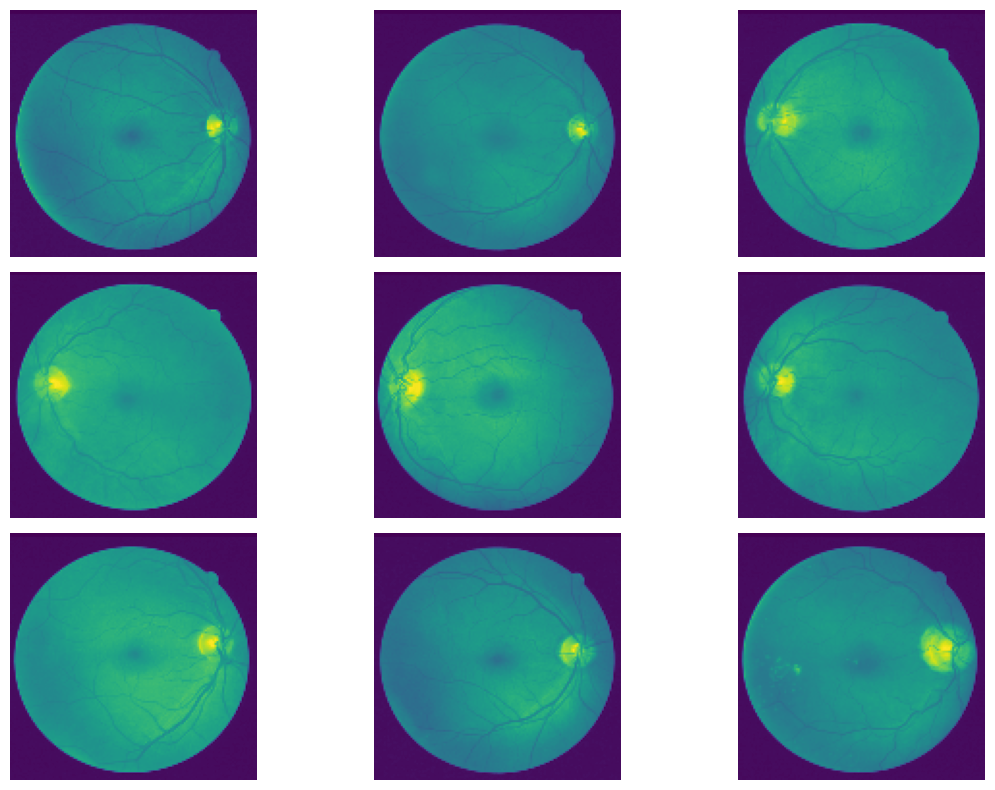

In [11]:
import matplotlib.pyplot as plt

# Function to display a grid of images
def display_images(images, titles=None, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.ravel()  # Flatten the axes array for easier iteration
    for i in range(min(rows * cols, len(images))):
        axes[i].imshow(images[i])
        if titles:
            axes[i].set_title(titles[i])
        axes[i].axis('off')  # Hide the axis ticks and labels
    plt.tight_layout()
    plt.show()

# Display some sample images from the training set
display_images(X_test[:9], rows=3, cols=3)

In [6]:
# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Flattened training data shape: {X_train_flat.shape}")
print(f"Flattened testing data shape: {X_test_flat.shape}")

Flattened training data shape: (80, 16384)
Flattened testing data shape: (20, 16384)


## Step 1: Apply Locally Linear Embedding (LLE)

Explanation:
1. Input Data: We use the flattened version of the image data (X_train_flat and X_test_flat).
2. n_neighbors: Determines the number of neighbors LLE considers while building the graph structure.
3. n_components: Defines the target dimensionality for the reduced data (2D here for visualization).

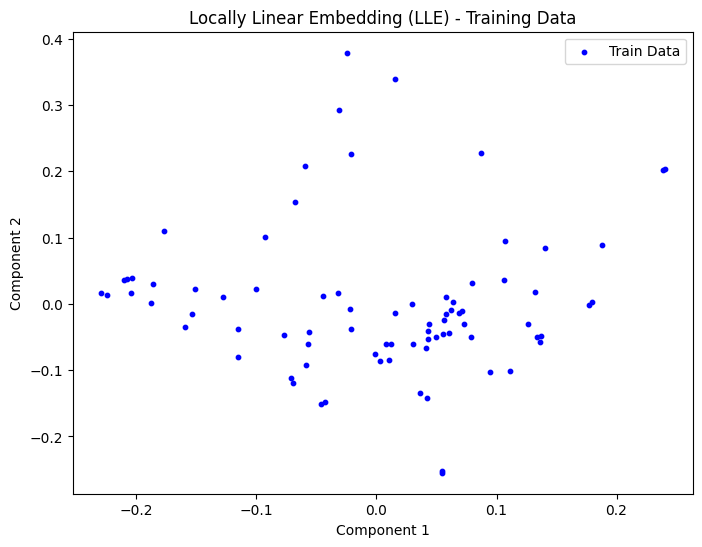

In [7]:
from sklearn.manifold import LocallyLinearEmbedding
import matplotlib.pyplot as plt

# Parameters for LLE
n_neighbors = 10  # Number of neighbors to consider for each point
n_components = 2  # Number of dimensions to reduce to

# Apply LLE
lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, method='standard')
X_train_lle = lle.fit_transform(X_train_flat)
X_test_lle = lle.transform(X_test_flat)

# Visualize the result (for the training set)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_lle[:, 0], X_train_lle[:, 1], c="blue", s=10, label="Train Data")
plt.title("Locally Linear Embedding (LLE) - Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

## Step 2: Apply t-SNE
Explanation:
1. Input Data: The flattened training data (X_train_flat).
2. perplexity: A key parameter that controls how t-SNE balances local and global relationships in the data. Typical values range between 5 and 50.
3. n_components: We reduce the data to 2D for visualization purposes.
4. Visualization: The scatter plot shows the reduced data in 2D, highlighting clusters and relationships.

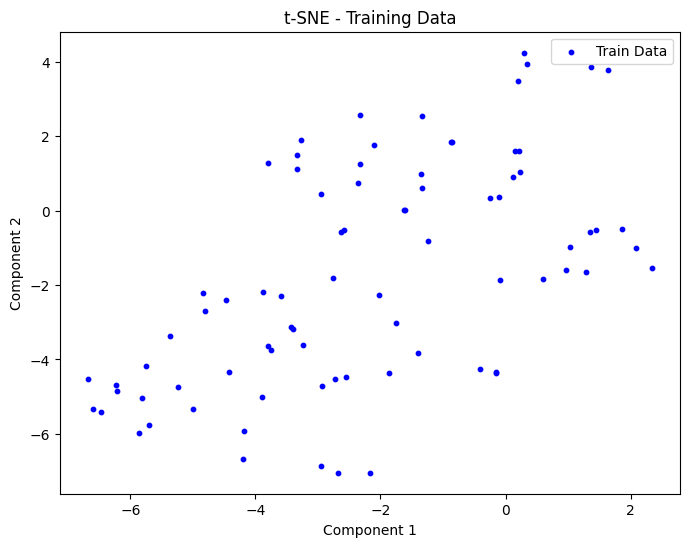

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Parameters for t-SNE
n_components = 2  # Number of dimensions to reduce to
perplexity = 30  # Controls the balance between local and global aspects of the data
random_state = 42  # For reproducibility

# Apply t-SNE
tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
X_train_tsne = tsne.fit_transform(X_train_flat)

# Visualize the result (for the training set)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c="blue", s=10, label="Train Data")
plt.title("t-SNE - Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


## Step 3: Apply ISOMAP
Explanation:
1. Input Data: The flattened training data (X_train_flat).
2. n_neighbors: Controls how many neighbors are considered in the graph construction, which defines the geodesic distances.
3. n_components: The dimensionality of the reduced data (2D here for visualization).
4. Output: ISOMAP reduces the data while preserving the global geometric structure.

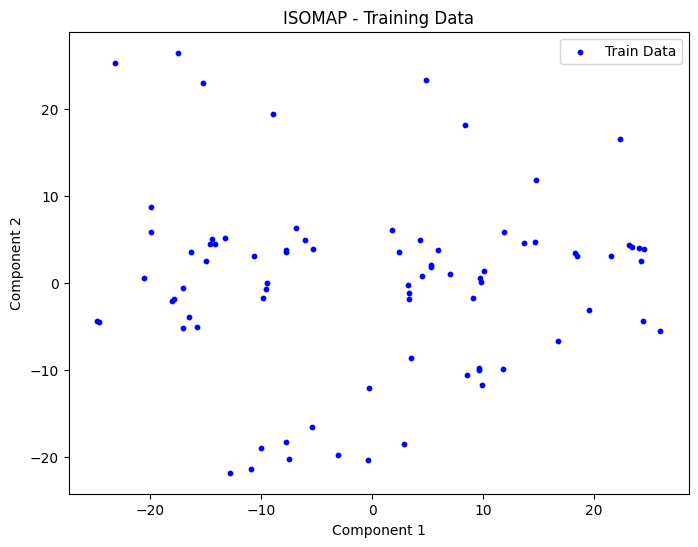

In [12]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

# Parameters for ISOMAP
n_neighbors = 10  # Number of neighbors to consider for each point
n_components = 2  # Number of dimensions to reduce to

# Apply ISOMAP
isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
X_train_isomap = isomap.fit_transform(X_train_flat)
X_test_isomap = isomap.transform(X_test_flat)

# Visualize the result (for the training set)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_isomap[:, 0], X_train_isomap[:, 1], c="blue", s=10, label="Train Data")
plt.title("ISOMAP - Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

## Step 4: Apply UMAP

1. n_neighbors: Determines the balance between local and global structure.
2. Higher values emphasize global structure, while lower values focus on local structure.
3. min_dist: Controls the minimum spacing between points in the low-dimensional  representation. Lower values result in denser clusters.
4. n_components: Reduces data to 2D for visualization.
random_state: Ensures reproducibility of the results.

In [13]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


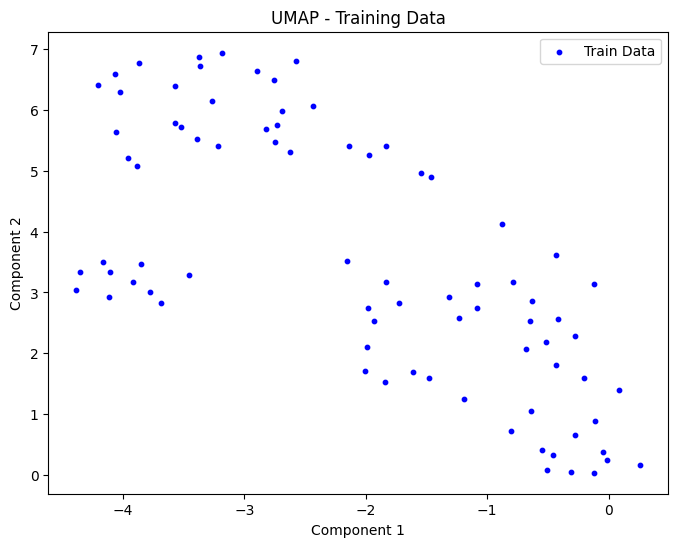

In [14]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Parameters for UMAP
n_neighbors = 15  # Number of neighbors considered for graph construction
min_dist = 0.1  # Minimum distance between points in the low-dimensional space
n_components = 2  # Number of dimensions to reduce to

# Apply UMAP
umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
X_train_umap = umap_reducer.fit_transform(X_train_flat)

# Visualize the result (for the training set)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c="blue", s=10, label="Train Data")
plt.title("UMAP - Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

## Step 5: Apply MDS

Explanation:
1. n_components: Specifies the dimensionality of the reduced data (2D here for visualization).
2. random_state: Ensures reproducibility of results.
3. n_init & max_iter: Control the optimization process for finding the best configuration.
4. Output: MDS reduces data while aiming to preserve pairwise distances between points.

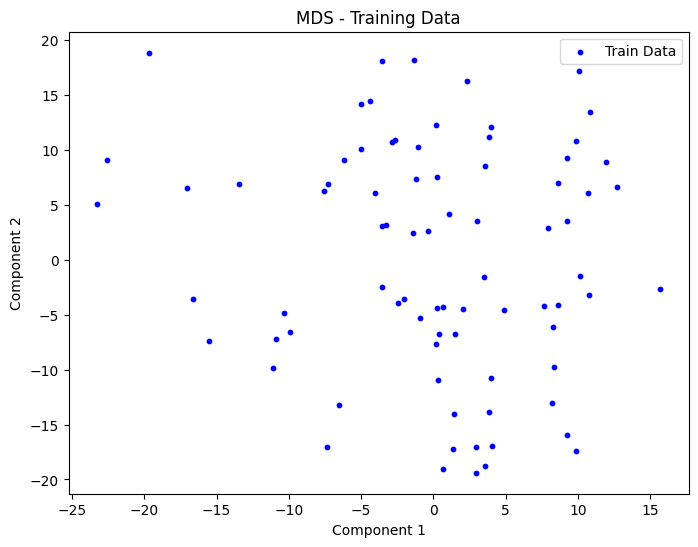

In [15]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Parameters for MDS
n_components = 2  # Number of dimensions to reduce to
random_state = 42  # For reproducibility

# Apply MDS
mds = MDS(n_components=n_components, random_state=random_state, n_init=4, max_iter=300)
X_train_mds = mds.fit_transform(X_train_flat)

# Visualize the result (for the training set)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_mds[:, 0], X_train_mds[:, 1], c="blue", s=10, label="Train Data")
plt.title("MDS - Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


## Step 6: Apply Randomized PCA

Explanation:
1. n_components: Specifies the target dimensionality for the reduced data (2D here for visualization).
2. svd_solver='randomized': This makes PCA faster by using randomized algorithms.
3. random_state: Ensures reproducibility.

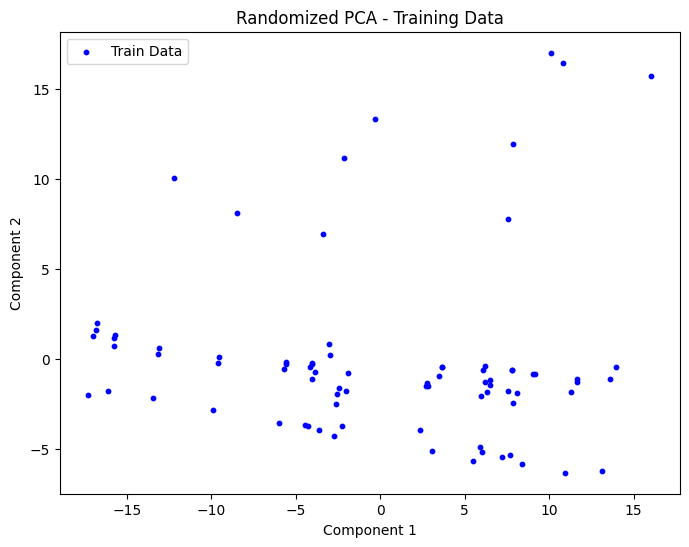

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Parameters for Randomized PCA
n_components = 2  # Number of dimensions to reduce to
random_state = 42  # For reproducibility

# Apply Randomized PCA
randomized_pca = PCA(n_components=n_components, svd_solver='randomized', random_state=random_state)
X_train_rpca = randomized_pca.fit_transform(X_train_flat)

# Visualize the result (for the training set)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_rpca[:, 0], X_train_rpca[:, 1], c="blue", s=10, label="Train Data")
plt.title("Randomized PCA - Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

## Step 7: Apply Kernel PCA

Explanation:
1. n_components: Specifies the number of reduced dimensions (2D for visualization).
2. kernel: Defines the type of kernel function to use.
Options include:
'linear': Equivalent to standard PCA.
'rbf': Radial basis function kernel (Gaussian kernel), often used for non-linear data.
'poly': Polynomial kernel.
3. gamma: Controls the influence of individual data points in the kernel computation (used for the 'rbf' and 'poly' kernels).

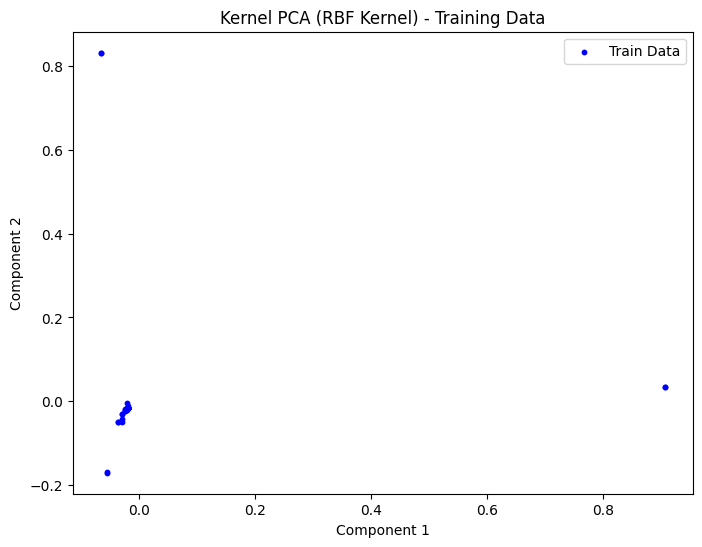

In [17]:
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

# Parameters for Kernel PCA
n_components = 2  # Number of dimensions to reduce to
kernel = 'rbf'  # Radial basis function kernel
gamma = 0.1  # Kernel coefficient for 'rbf'

# Apply Kernel PCA
kernel_pca = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma)
X_train_kpca = kernel_pca.fit_transform(X_train_flat)

# Visualize the result (for the training set)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_kpca[:, 0], X_train_kpca[:, 1], c="blue", s=10, label="Train Data")
plt.title("Kernel PCA (RBF Kernel) - Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


## Step 8: Apply Incremental PCA

Explanation:
1. n_components: Number of dimensions to reduce the data to (2D here for visualization).
2. batch_size: Specifies the number of samples to process at a time. Adjust this based on available memory.
3. fit_transform: Processes the training data incrementally, making it suitable for large datasets.


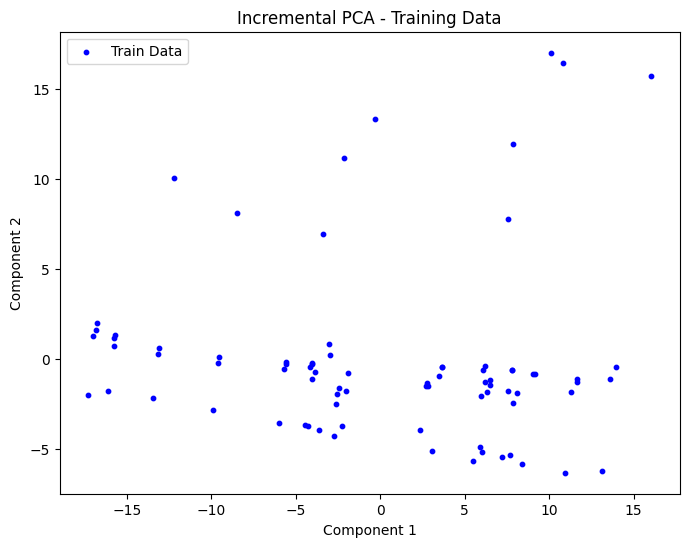

In [18]:
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

# Parameters for Incremental PCA
n_components = 2  # Number of dimensions to reduce to
batch_size = 100  # Process data in chunks

# Apply Incremental PCA
incremental_pca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
X_train_ipca = incremental_pca.fit_transform(X_train_flat)

# Visualize the result (for the training set)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_ipca[:, 0], X_train_ipca[:, 1], c="blue", s=10, label="Train Data")
plt.title("Incremental PCA - Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

## Step 9: Apply Factor Analysis

Explanation:
1. n_components: Specifies the number of factors (latent variables) to extract (2D here for visualization).
2. fit_transform: Fits the model to the training data and reduces its dimensionality.
3. random_state: Ensures reproducibility of results.

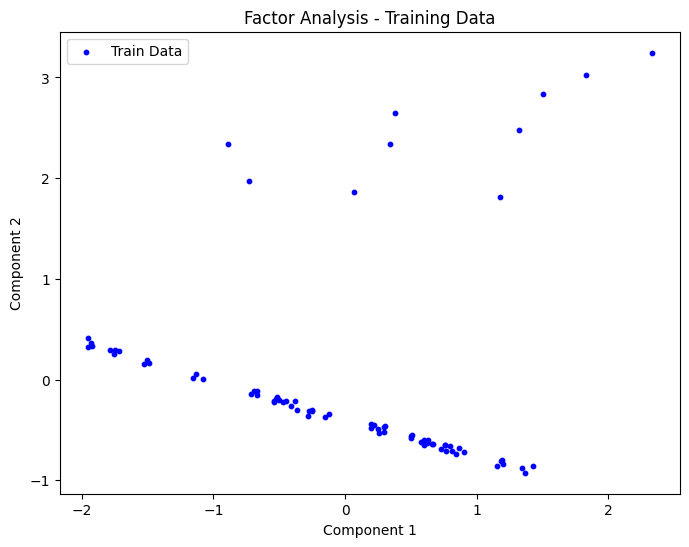

In [19]:
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt

# Parameters for Factor Analysis
n_components = 2  # Number of dimensions to reduce to

# Apply Factor Analysis
factor_analysis = FactorAnalysis(n_components=n_components, random_state=42)
X_train_fa = factor_analysis.fit_transform(X_train_flat)

# Visualize the result (for the training set)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_fa[:, 0], X_train_fa[:, 1], c="blue", s=10, label="Train Data")
plt.title("Factor Analysis - Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

## Step 10: Apply Autoencoders

Explanation:
Architecture:
1. Encoder: Reduces input to a latent representation (2D here).
2. Decoder: Reconstructs input from the latent representation.
3. Loss Function: Mean squared error (mse) measures reconstruction error.
4. Training: Trains the model to minimize reconstruction error and learns the compressed representation.

In [20]:
!pip install tensorflow --quiet

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0782 - val_loss: 0.0784
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 0.0781 - val_loss: 0.0782
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0779 - val_loss: 0.0775
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0773 - val_loss: 0.0764
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0761 - val_loss: 0.0747
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0744 - val_loss: 0.0724
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 0.0721 - val_loss: 0.0694
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.0691 - val_loss: 0.0658
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0655 - val_loss: 0.0617
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0613 - val_loss: 0.0571
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0566 - val_loss: 0.0521
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0517 - val_loss:

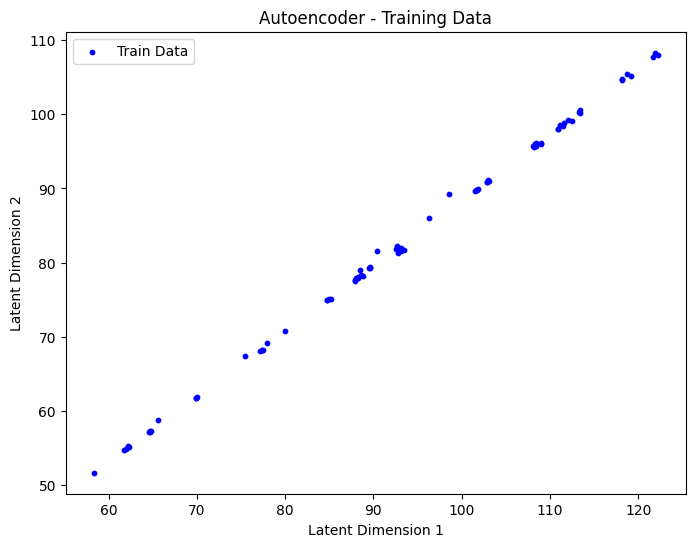

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Parameters
input_dim = X_train_flat.shape[1]  # Number of input features (flattened image size)
encoding_dim = 2  # Number of dimensions to reduce to

# Build the Autoencoder model
input_img = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(input_img, decoded)
encoder = models.Model(input_img, encoded)

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
autoencoder.fit(X_train_flat, X_train_flat,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_split=0.2)

# Apply the encoder to reduce dimensionality
X_train_autoencoded = encoder.predict(X_train_flat)

# Visualize the result (for the training set)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_autoencoded[:, 0], X_train_autoencoded[:, 1], c="blue", s=10, label="Train Data")
plt.title("Autoencoder - Training Data")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()

In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Parameters
input_dim = X_train_flat.shape[1]  # Number of input features (flattened image size)
encoding_dim = 3  # Number of dimensions to reduce to

# Build the Autoencoder model
input_img = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(input_img, decoded)
encoder = models.Model(input_img, encoded)

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
autoencoder.fit(X_train_flat, X_train_flat,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_split=0.2)

# Apply the encoder to reduce dimensionality
X_train_autoencoded = encoder.predict(X_train_flat)



Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step - loss: 0.0782 - val_loss: 0.0783
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0780 - val_loss: 0.0779
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0776 - val_loss: 0.0771
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0769 - val_loss: 0.0761
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0758 - val_loss: 0.0746
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0743 - val_loss: 0.0727
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0724 - val_loss: 0.0702
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0698 - val_loss: 0.0670
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0667 - val_loss: 0.0633
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0629 - val_loss: 0.0591
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0587 - val_loss: 0.0546
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0540 - val_loss: 0.0

In [42]:
data_3d = pd.DataFrame(X_train_autoencoded, columns=["Component 1", "Component 2", "Component 3"])
# Create a 3D scatter plot
fig = px.scatter_3d(data_3d,
                    x="Component 1",
                    y="Component 2",
                    z="Component 3",
                    # color="Label",
                    title="Kernel PCA 3D Interactive Visualization",
                    labels={'Label': 'Class Label'},
                    template="plotly_dark")  # Optional: Use a dark theme

# Show the interactive plot
fig.show()

In [30]:
from sklearn.manifold import TSNE

# Parameters for t-SNE
n_components = 3  # Reduce to 3 dimensions for 3D plotting
perplexity = 30
random_state = 42

# Apply t-SNE with 3 components
tsne_3d = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
X_train_tsne_3d = tsne_3d.fit_transform(X_train_flat)


In [32]:
data_3d = pd.DataFrame(X_train_tsne_3d, columns=["Component 1", "Component 2", "Component 3"])

In [34]:
import plotly.express as px

# Create a 3D scatter plot
fig = px.scatter_3d(data_3d,
                    x="Component 1",
                    y="Component 2",
                    z="Component 3",
                    # color="Label",
                    title="t-SNE 3D Interactive Visualization",
                    labels={'Label': 'Class Label'},
                    template="plotly_dark")  # Optional: Use a dark theme

# Show the interactive plot
fig.show()

In [35]:
# Parameters for Kernel PCA
n_components = 3  # Number of dimensions to reduce to
kernel = 'rbf'  # Radial basis function kernel
gamma = 0.1  # Kernel coefficient for 'rbf'

# Apply Kernel PCA
kernel_pca = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma)
X_train_kpca_3d = kernel_pca.fit_transform(X_train_flat)

In [36]:
data_3d = pd.DataFrame(X_train_kpca_3d, columns=["Component 1", "Component 2", "Component 3"])

In [38]:
# Create a 3D scatter plot
fig = px.scatter_3d(data_3d,
                    x="Component 1",
                    y="Component 2",
                    z="Component 3",
                    # color="Label",
                    title="Kernel PCA 3D Interactive Visualization",
                    labels={'Label': 'Class Label'},
                    template="plotly_dark")  # Optional: Use a dark theme

# Show the interactive plot
fig.show()